## Imports
First, we import dependencies for processing API requests and JSON.

In [27]:
import json
import requests

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

These are some helper functions for arguments to the Wikimedia API.

In [28]:
# accessType = all-sites, desktop-site, mobile-site
def getLegacyParams(accessType):
    return {"project" : "en.wikipedia.org",
            "access-site" : accessType,
            "granularity" : "monthly",
            "start" : "2001010100",
        # for end use 1st day of month following final month of data
            "end" : "2020100100"
            }

# accessType = all-access, desktop, mobile-app, mobile-web
def getPageViewParams(accessType):
    return {"project" : "en.wikipedia.org",
            "access" : accessType,
            "agent" : "user",
            "granularity" : "monthly",
            "start" : "2001010100",
            # for end use 1st day of month following final month of data
            "end" : '2020101000'
                }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/jfrei86',
    'From': 'jefre@uw.edu'
}

This is the utility that was provided for the assignment for making API calls to Wikimedia.

In [29]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

These are utilities for generating filenames.

In [30]:
def getJsonFileName(apiname, accesstype, firstmonth, lastmonth):
    return '_'.join([apiname, accesstype, firstmonth]) + '-' + lastmonth + '.json'

def getCsvFileName():
    return 'en-wikipedia_traffic_200712-202008.csv'

### Step 1: Download data
In order to measure Wikipedia traffic from 2008-2020, we will need to collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

For each API, we will need to collect data for all months where data is available and then save the raw results into 5 separate JSON source data files (one file per API query type).

The naming convention for the source data files is:

```
apiname_accesstype_firstmonth-lastmonth.json
```

In [31]:
apiName = ['pageviews', 'legacy']
accessTypeLegacy = ['desktop-site', 'mobile-site']
accessTypePageViews = ['desktop', 'mobile-app', 'mobile-web']

for accessType in accessTypeLegacy:
    results = api_call(endpoint_legacy, getLegacyParams(accessType))
    # Writing to sample.json 
    with open(getJsonFileName('legacy', accessType, results['items'][0]['timestamp'], results['items'][-1]['timestamp']), "w") as outfile: 
        outfile.write(json.dumps(results))

for accessType in accessTypePageViews:
    results = api_call(endpoint_pageviews, getPageViewParams(accessType))
    # Writing to sample.json 
    with open(getJsonFileName('pageviews', accessType, results['items'][0]['timestamp'], results['items'][-1]['timestamp']), "w") as outfile: 
        outfile.write(json.dumps(results)) 



### Step 2: Create a CSV file from the data
We will need to perform a series of processing steps on these data files in order to prepare them for analysis. At the end of this step, we will have a single CSV-formatted data file that can be used in our analysis (step 3) with no significant additional processing.

For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
For all data, we separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

Then we write the file to a CSV. In the next step we will reorganize the data so that each row is a unique month and year.


In [32]:
files = ['legacy_desktop-site_2007120100-2016080100.json', 'legacy_mobile-site_2014100100-2016080100.json', 'pageviews_desktop_2015070100-2020090100.json', 'pageviews_mobile-app_2015070100-2020090100.json', 'pageviews_mobile-web_2015070100-2020090100.json']

final = 'en-wikipedia_traffic_200712-202008.csv'
rows = []

for file in files:
    with open(file) as infile:
        result = json.load(infile)
        for item in result['items']:
            year = item['timestamp'][0:4]
            month = item['timestamp'][4:6]
            pagecount_all_views = item.get('count') if item.get('count') != None else 0
            pagecount_desktop_views = item.get('count') if item.get('access-site') == 'desktop-site' else 0
            pagecount_mobile_views = item.get('count') if item.get('access-site') == 'mobile-site' else 0
            pageview_all_views = item.get('views') if item.get('views') != None else 0
            pageview_desktop_views = item.get('views') if item.get('access') == 'desktop' else 0
            pageview_mobile_views = item.get('views') if item.get('access') != 'desktop' and item.get('access') != None else 0
            rows.append(','.join([year, month, str(pagecount_all_views), str(pagecount_desktop_views), str(pagecount_mobile_views), str(pageview_all_views), str(pageview_desktop_views), str(pageview_mobile_views)]))

with open(final, "w") as outfile:
    outfile.write('year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views\n')
    outfile.write('\n'.join(rows))



In this step, we group by month and year. We aggregate by sum of page views.

In [33]:
import pandas as pd

data_raw = pd.read_csv(final)
data_cleaned = data_raw.groupby(["year","month"]).sum()
data_cleaned.to_csv(final)

### Step 3: Visualize the data
Our visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop). These different sources of traffic are be graphed separately whenever it is possible to do so.

<AxesSubplot:ylabel='Total'>

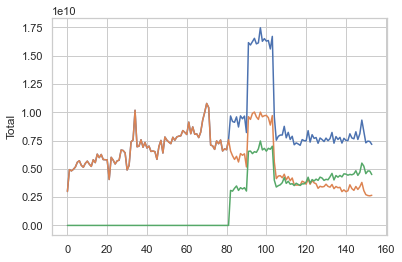

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

data_raw = pd.read_csv(final)
data_raw["Total"] = data_raw["pageview_all_views"] + data_raw["pagecount_all_views"]
data_raw["Mobile Site"] = data_raw["pageview_mobile_views"] + data_raw["pagecount_mobile_views"]
data_raw["Desktop Site"] = data_raw["pageview_desktop_views"] + data_raw["pagecount_desktop_views"]
sns.lineplot(data=data_raw['Total'], palette="tab10", linewidth=1.5, dashes=True)
sns.lineplot(data=data_raw['Desktop Site'], palette="tab10", linewidth=1.5)
sns.lineplot(data=data_raw['Mobile Site'], palette="tab10", linewidth=1.5)